In [1]:
import sys
from collections import namedtuple

import numpy as np

%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import matplotlib
matplotlib.style.use('ggplot')

from joblib import Parallel, delayed  
import multiprocessing

np.random.seed(666)

import pandas as pd
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

In [2]:
## LSST imports:
import lsst.utils.tests as tests
import lsst.daf.base as dafBase
#import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import lsst.afw.geom as afwGeom
import lsst.afw.table as afwTable
import lsst.afw.math as afwMath
import lsst.meas.algorithms as measAlg
import lsst.ip.diffim as ipDiffim

In [37]:
def dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg, psfWidth, fluxNeg=None, sigma2=None, ampl2=0.1, afw=False):
    """
    Dipole based on 2-d (potentially [TBD] ellipsoidal) double-gaussian: 
    dipoleFunc(x, flux, xcenPos, ycenPos, xcenNeg, ycenNeg) #, sig1, sig2)
    """
    if fluxNeg is None:
        fluxNeg = flux
        
    if sigma2 is None:
        sigma2 = psfWidth * 1.75
        
    if afw:
        ## Wow - this is about 3x slower than the below (pure python)...
        generator = afwMath.DoubleGaussianFunction2D(psfWidth, sigma2, ampl2)
        zout = np.array([generator(x[0][i] - xcenPos, x[1][i] - ycenPos) for i in xrange(len(x[0]))])
        zout *= flux
        if fluxNeg != 0. and sigma2 != 0.0:
            zout2 = np.array([generator(x[0][i] - xcenNeg, x[1][i] - ycenNeg) for i in xrange(len(x[0]))])
            zout2 *= fluxNeg
            zout -= zout2

    else: ## don't have stack installed, use a custom double gaussian2d generator. This is faster!
        def singleGaussian2d(x, y, xc, yc, sigma_x=1., sigma_y=1., theta=0., offset=0.):
            cos_theta2, sin_theta2 = np.cos(theta)**2., np.sin(theta)**2.
            sigma_x2, sigma_y2 = sigma_x**2., sigma_y**2.
            a = cos_theta2/(2.*sigma_x2) + sin_theta2/(2.*sigma_y2)
            b = -(np.sin(2.*theta))/(4.*sigma_x2) + (np.sin(2.*theta))/(4.*sigma_y2)
            c = sin_theta2/(2.*sigma_x2) + cos_theta2/(2.*sigma_y2)
            xxc, yyc = x-xc, y-yc
            out = np.exp( - (a*(xxc**2.) + 2.*b*xxc*yyc + c*(yyc**2.)))
            if offset != 0.:
                out += offset
            return out

#      * double Guassian (sum of two Gaussians)
#      *
#      * Intended for use as a PSF model: the main Gaussian represents the core
#      * and the second Gaussian represents the wings.
#      *
#      * f(x,y) = A (e^(-r^2 / 2 sigma1^2) + ampl2 e^(-r^2 / 2 sigma2^2))
#      * where:
#      * * A = 1 / (2 pi (sigma1^2 + ampl2 sigma2^2))
#      * * r^2 = x^2 + y^2
#      * coefficients c[0] = sigma1, c[1] = sigma2, c[2] = ampl2
#       def doubleGaussian2d(x, y, xc, yc, sigma1=1., sigma2=1., ampl2=0.1):
        sigma1 = psfWidth
        multFac = 1.0 / (2. * np.pi)
        sigma1sq = sigma1**2.
        sigma2sq = sigma2**2.
        b = ampl2
#           out = (multFac / (sigma1Sq + (b * sigma2Sq))) *
#              (np.exp(-radSq / (2.0 * sigma1Sq)) + 
#              (b * np.exp(-radSq / (2.0 * sigma2Sq)))));

        #print xcenPos, xcenNeg, ycenPos, ycenNeg
        tmp1 = singleGaussian2d(x[0], x[1], xcenPos, ycenPos, sigma1, sigma1)
        tmp2 = singleGaussian2d(x[0], x[1], xcenPos, ycenPos, sigma2, sigma2)
        ampl1 = multFac / (sigma1sq + b * sigma2sq)
        zout = ampl1 * (tmp1 + tmp2 * ampl2)
        zout *= flux
        if fluxNeg != 0. and sigma2 != 0.0:
            tmp1 = singleGaussian2d(x[0], x[1], xcenNeg, ycenNeg, sigma1, sigma1)
            tmp2 = singleGaussian2d(x[0], x[1], xcenNeg, ycenNeg, sigma2, sigma2)
            zout2 = ampl1 * (tmp1 + tmp2 * ampl2)
            zout2 *= flux
            zout -= zout2

    return zout

In [38]:
w, h = 51, 51
xc, yc = 25, 25
rotAngle = 0.
separation = 2.4
sep = 0. #separation / 2.
psfWidth = 2.
flux = 1.

rotAngRad = rotAngle / 180. * np.pi

y, x = np.mgrid[:w, :h]
x = x.ravel()
y = y.ravel()
in_x = [x, y]

z1 = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad), psfWidth, fluxNeg=0., afw=False)
z2 = dipoleFunc(in_x, flux, xc+sep*np.cos(rotAngRad), yc+sep*np.sin(rotAngRad), 
                   xc-sep*np.cos(rotAngRad), yc-sep*np.sin(rotAngRad), psfWidth, fluxNeg=0., afw=True)

0.0335063038088 2.11763987987e-25 1.0
0.0335063038088 2.11763987987e-25 1.0
0.0 -2.16840434497e-19 -1.29600892509e-17


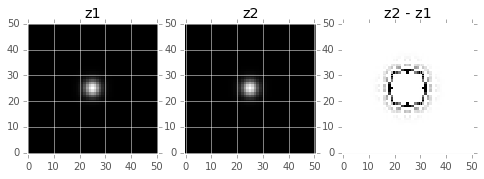

In [39]:
print z1.max(), z1.min(), z1.sum()
print z2.max(), z2.min(), z2.sum()
print (z2-z1).max(), (z2-z1).min(), (z2-z1).sum()

plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(z1.reshape(w, h), origin='lower', interpolation='none', cmap='gray')#, vmin=-zptp, vmax=zptp)
plt.title("z1")
plt.subplot(1, 3, 2)
plt.imshow(z2.reshape(w, h), origin='lower', cmap='gray', interpolation='none')
plt.title("z2")
plt.subplot(1, 3, 3)
plt.imshow((z2-z1).reshape(w, h), origin='lower', cmap='gray', interpolation='none')
plt.title("z2 - z1")